In [11]:
library(tidyverse)     # For data manipulation & visualization
library(janitor)       # For cleaning column names
library(corrplot)      # For correlation plots
library(scales)        # For percentage scales in ggplot
library(brms)   # For Bayesian regression
library(bayesplot)  # For diagnostics & posterior checks

In [12]:
usvotes <- read_csv("USvotes.csv") %>% 
  clean_names()   # Standardize column names to snake_case

Rows: 3107 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): STNAME, CTYNAME
dbl (7): TOT_POP, TOT_MALE, TOT_FEMALE, total_votes, per_gop, Crude.Prevalen...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [13]:
# Create binary variable for majority GOP
usvotes <- usvotes %>%
  mutate(
    majority_gop = if_else(per_gop > 50, 1, 0),
    scaled_depression = scale(crude_prevalence_estimate),
    scaled_race = scale(race),
    log_pop = scale(log(tot_pop)),
    turnout_rate = total_votes / tot_pop,
    state = as.factor(stname)
  )


In [47]:
usvotes <- usvotes %>% drop_na(per_gop, crude_prevalence_estimate, race)

# EDA

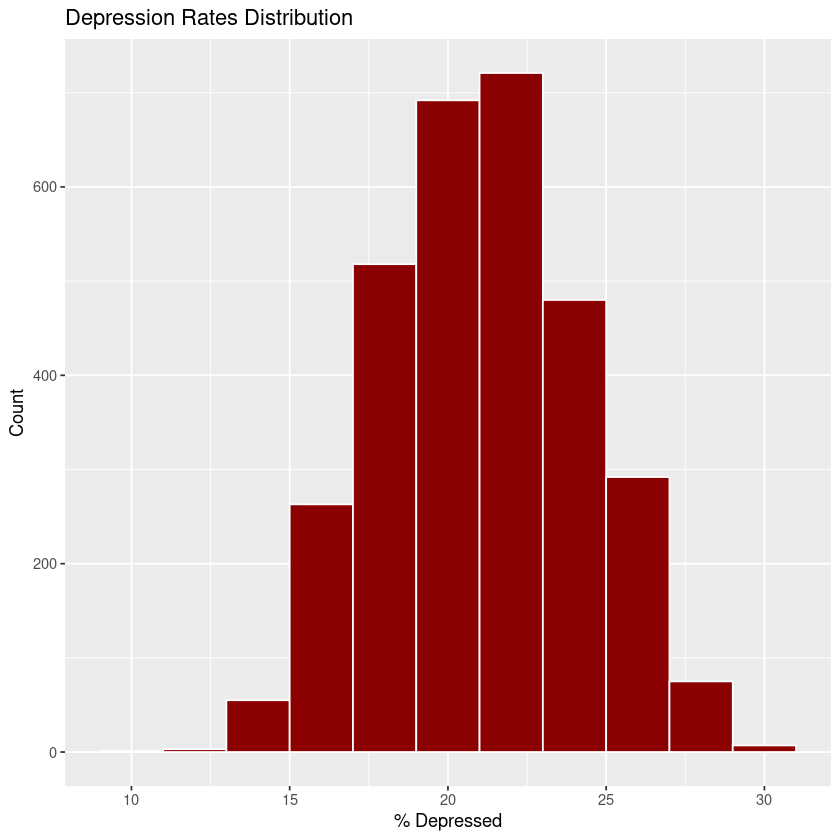

In [16]:
ggplot(usvotes, aes(x = crude_prevalence_estimate)) +
  geom_histogram(binwidth = 2, fill = "darkred", color = "white") +
  labs(title = "Depression Rates Distribution", x = "% Depressed", y = "Count")

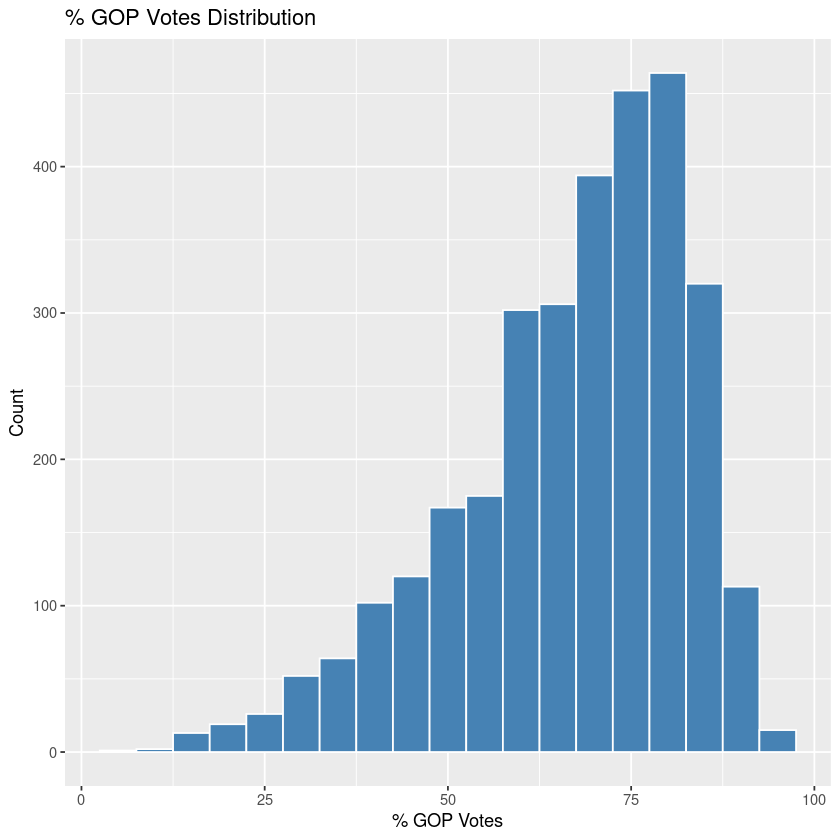

In [17]:
ggplot(usvotes, aes(x = per_gop)) +
  geom_histogram(binwidth = 5, fill = "steelblue", color = "white") +
  labs(title = "% GOP Votes Distribution", x = "% GOP Votes", y = "Count")


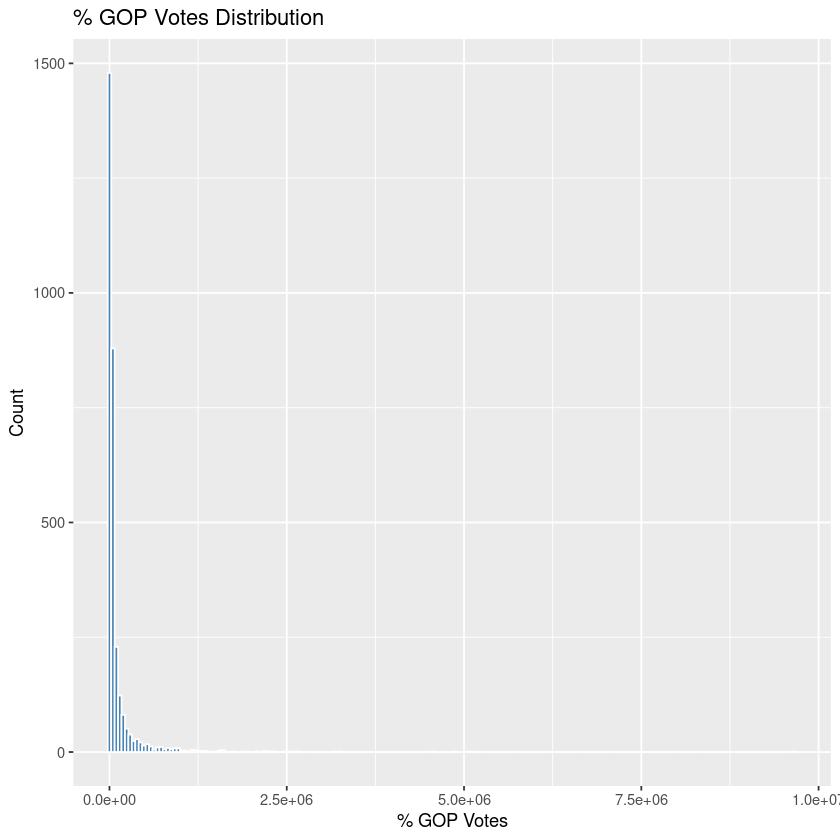

In [ ]:
ggplot(usvotes, aes(x = tot_pop)) +
  geom_histogram(bins=200, fill = "steelblue", color = "white") +
  labs(title = "Population Distribution", x = "% GOP Votes", y = "Count")


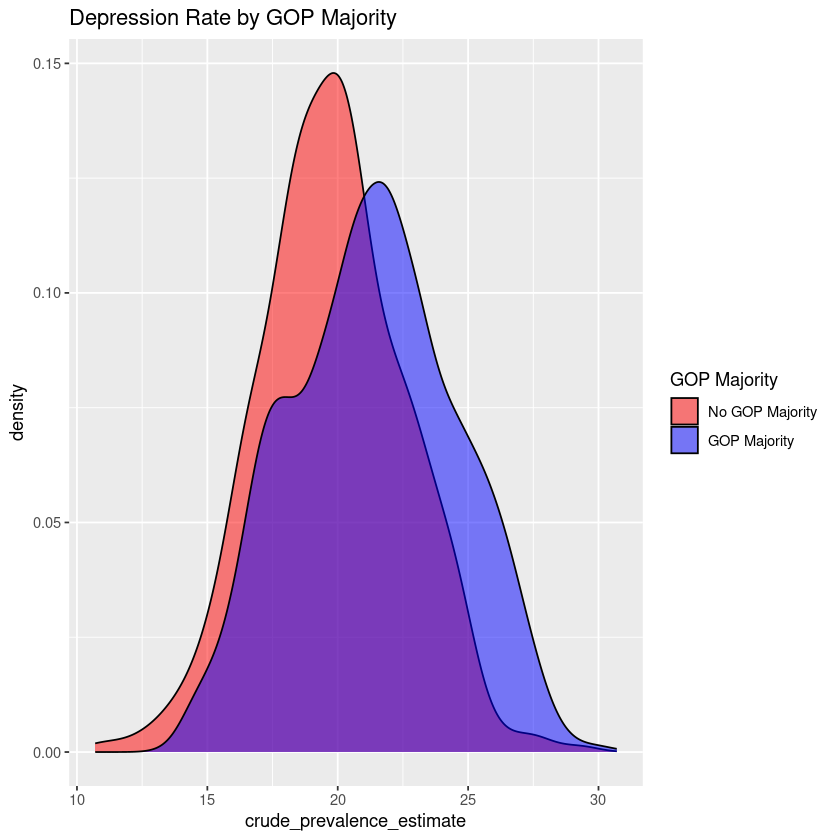

In [50]:
ggplot(usvotes, aes(x = crude_prevalence_estimate, fill = factor(majority_gop))) +
  geom_density(alpha = 0.5) +
  scale_fill_manual(values = c("0" = "red", "1" = "blue"),
                  labels = c("No GOP Majority", "GOP Majority")) +

  labs(title = "Depression Rate by GOP Majority", fill = "GOP Majority")


`geom_smooth()` using formula = 'y ~ x'


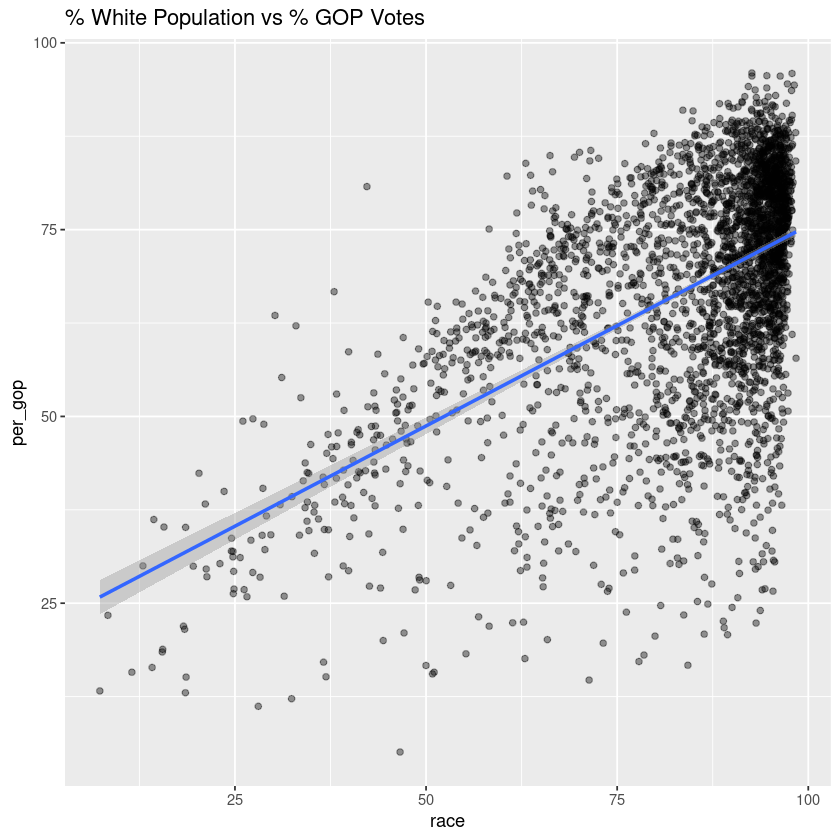

In [51]:
ggplot(usvotes, aes(x = race, y = per_gop)) +
  geom_point(alpha = 0.4) +
  geom_smooth(method = "lm") +
  labs(title = "% White Population vs % GOP Votes")


`geom_smooth()` using formula = 'y ~ x'


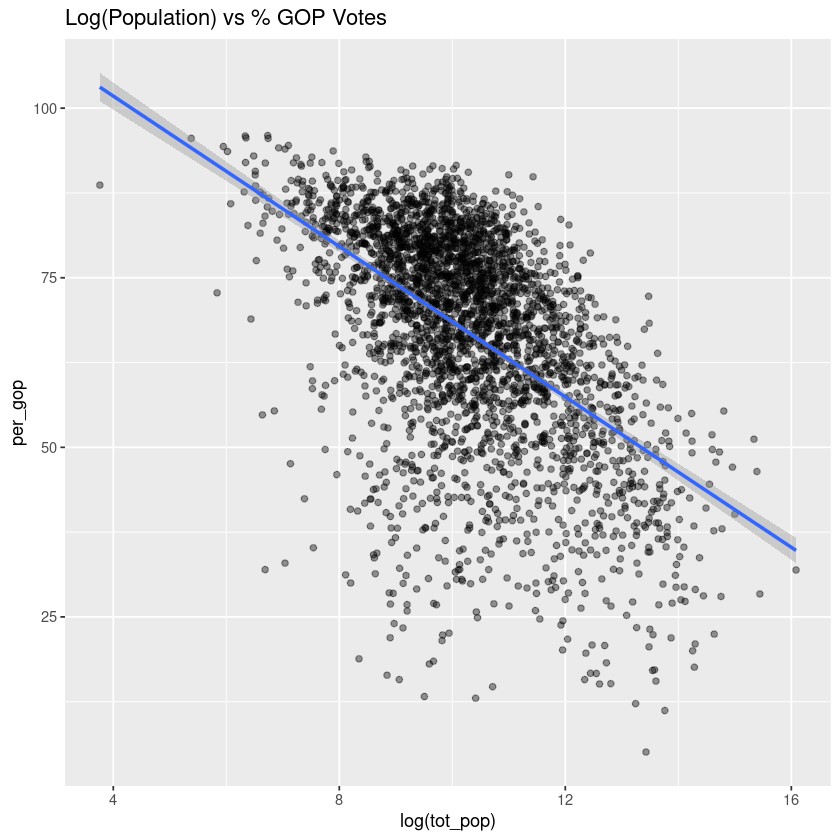

In [52]:
ggplot(usvotes, aes(x = log(tot_pop), y = per_gop)) +
  geom_point(alpha = 0.4) +
  geom_smooth(method = "lm") +
  labs(title = "Log(Population) vs % GOP Votes")


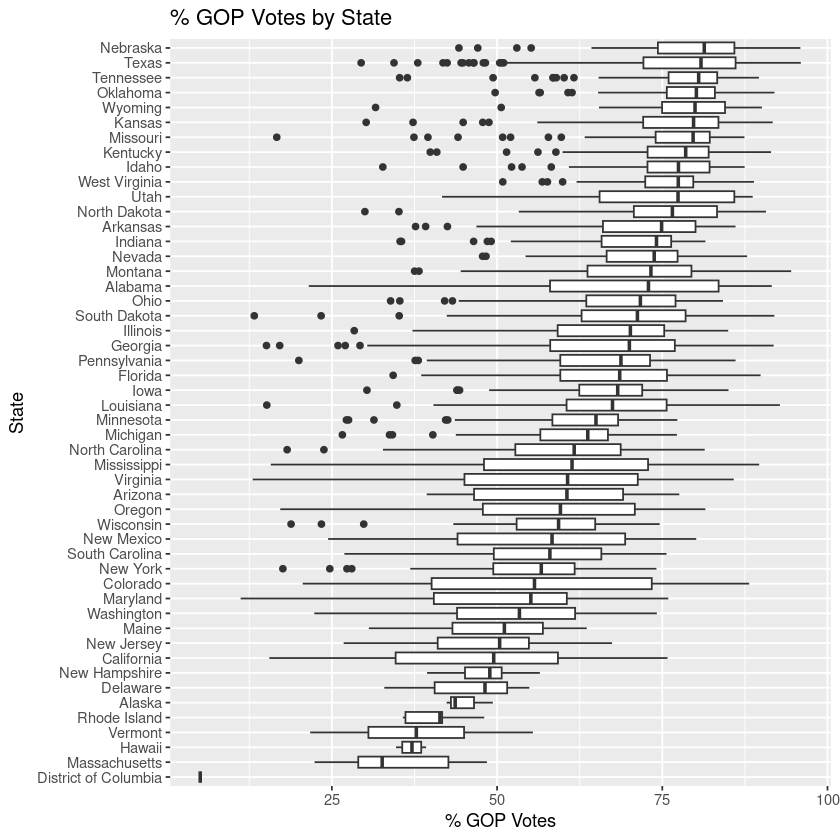

In [53]:
ggplot(usvotes, aes(x = reorder(state, per_gop, median), y = per_gop)) +
  geom_boxplot() +
  coord_flip() +
  labs(title = "% GOP Votes by State", x = "State", y = "% GOP Votes")


`geom_smooth()` using formula = 'y ~ x'


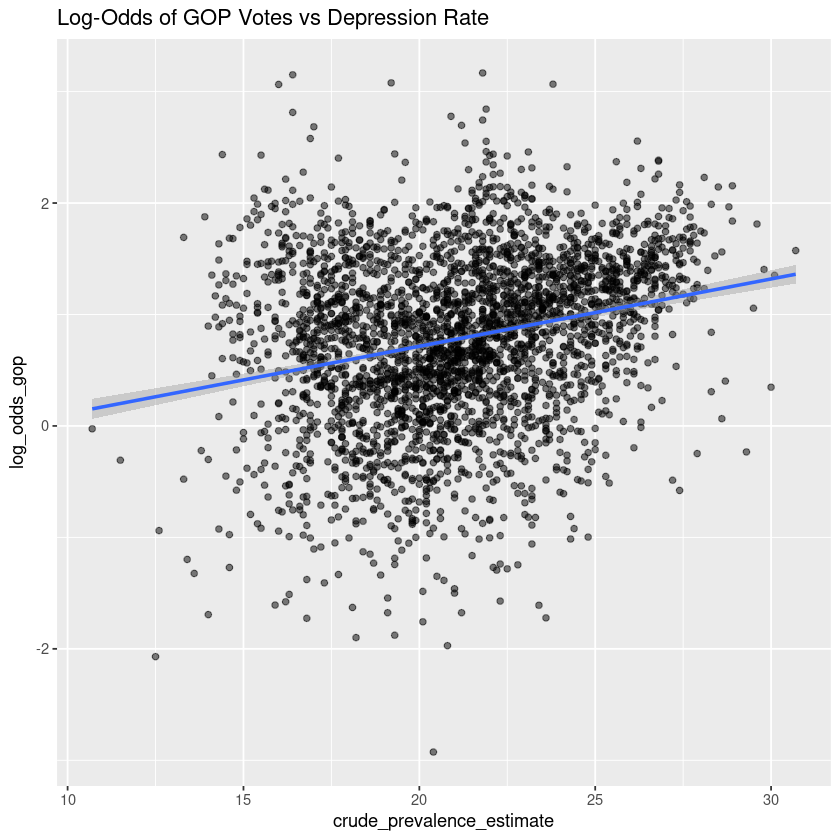

In [54]:
usvotes <- usvotes %>%
  mutate(log_odds_gop = log((per_gop + 0.01) / (100.01 - per_gop)))

ggplot(usvotes, aes(x = crude_prevalence_estimate, y = log_odds_gop)) +
  geom_point(alpha = 0.5) +
  geom_smooth(method = "lm") +
  labs(title = "Log-Odds of GOP Votes vs Depression Rate")


`geom_smooth()` using formula = 'y ~ x'


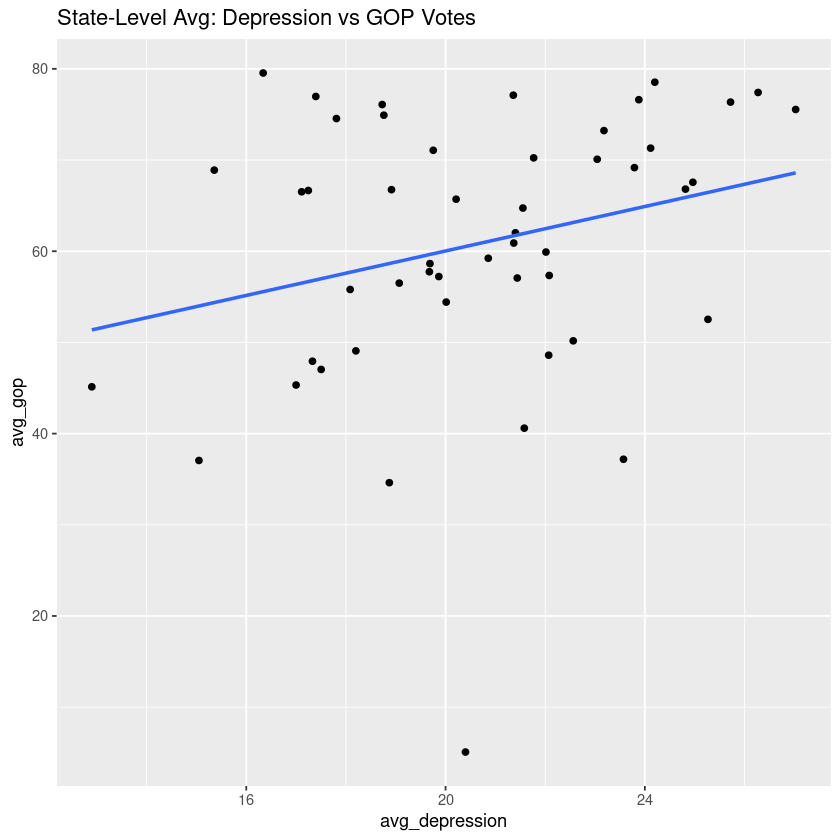

In [55]:
state_summary <- usvotes %>%
  group_by(state) %>%
  summarise(
    avg_gop = mean(per_gop),
    avg_depression = mean(crude_prevalence_estimate),
    avg_race = mean(race)
  )

ggplot(state_summary, aes(x = avg_depression, y = avg_gop)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE) +
  labs(title = "State-Level Avg: Depression vs GOP Votes")


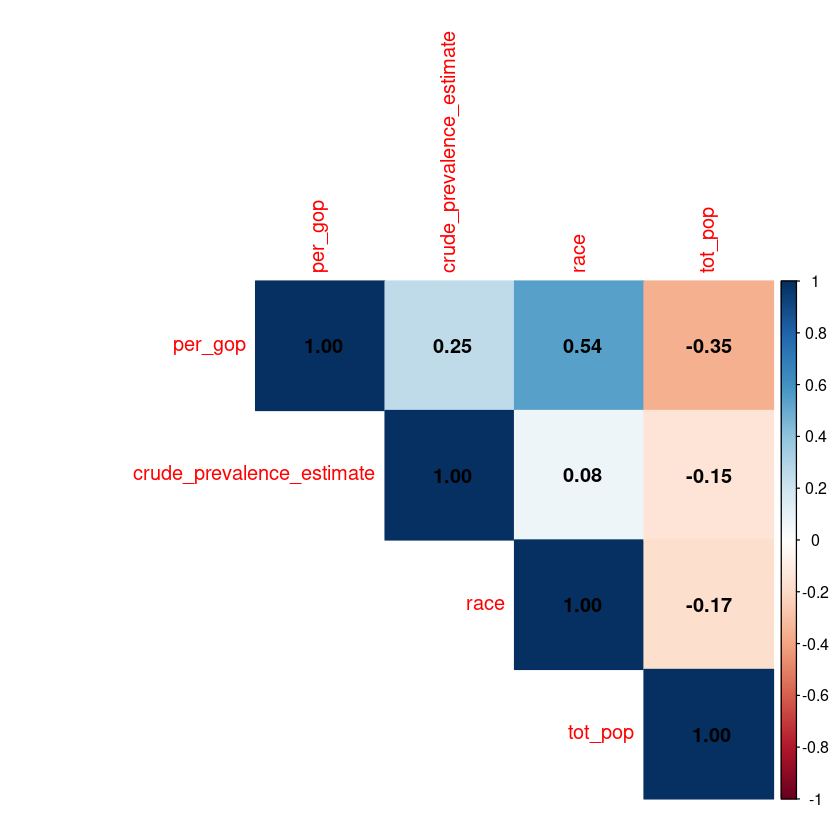

In [56]:
cor_vars <- usvotes %>% select(per_gop, crude_prevalence_estimate, race, tot_pop) %>% cor()
corrplot(cor_vars, method = "color", type = "upper", addCoef.col = "black")


# Modeling

### Full model

In [57]:
prior <- c(
  set_prior("normal(0, 2)", class = "b"),
  set_prior("student_t(3, 0, 2.5)", class = "Intercept")
)

In [58]:
model <- brm(
  majority_gop ~ scaled_depression + scaled_race + log(tot_pop) + (1 | state),
  data = usvotes,
  family = bernoulli(),
  prior = prior,
  chains = 4,
  iter = 4000,
  cores = 10,
  seed = 123
)


Compiling Stan program...

Start sampling



In [59]:
summary(model)

 Family: bernoulli 
  Links: mu = logit 
Formula: majority_gop ~ scaled_depression + scaled_race + log(tot_pop) + (1 | state) 
   Data: usvotes (Number of observations: 3107) 
  Draws: 4 chains, each with iter = 4000; warmup = 2000; thin = 1;
         total post-warmup draws = 8000

Multilevel Hyperparameters:
~state (Number of levels: 50) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     2.21      0.28     1.72     2.80 1.00     1396     2715

Regression Coefficients:
                  Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept             9.37      0.74     7.92    10.84 1.00     1882     2927
scaled_depression     0.99      0.18     0.65     1.33 1.00     3022     4433
scaled_race           1.86      0.11     1.65     2.09 1.00     4407     5172
logtot_pop           -0.66      0.06    -0.78    -0.55 1.00     5655     5648

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effec

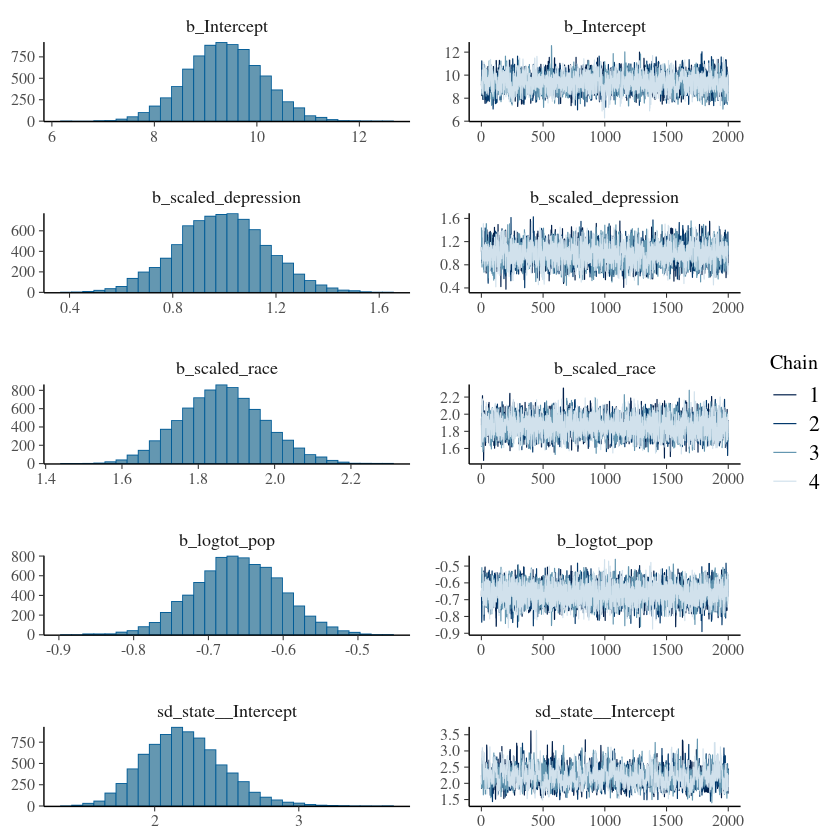

In [60]:
plot(model)

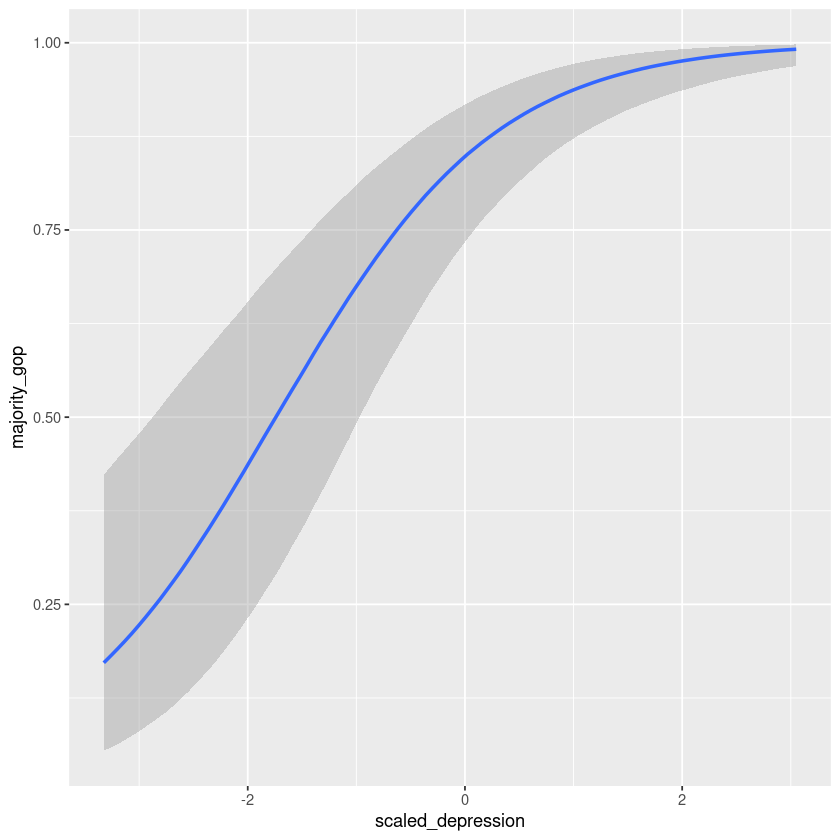

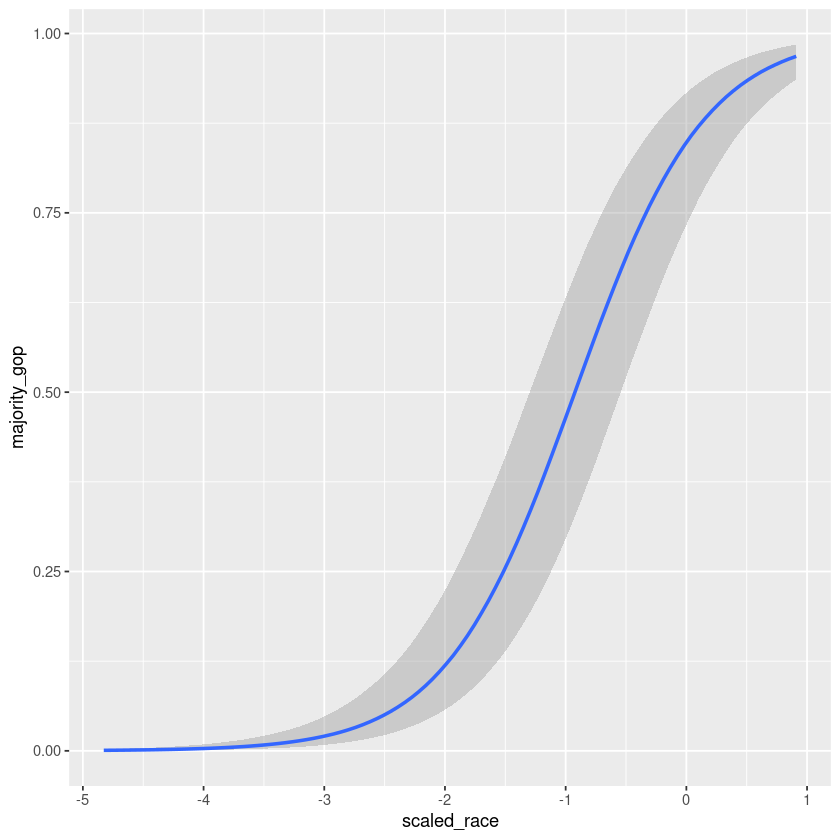

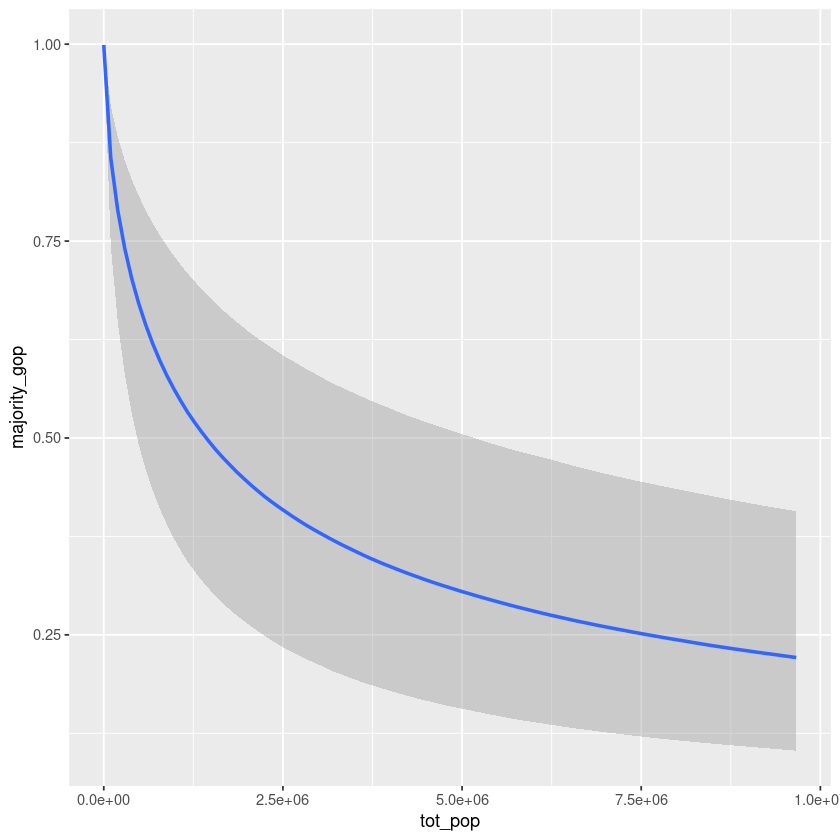

In [61]:
conditional_effects(model)

In [62]:
print(ranef(model)$state)

, , Intercept

                        Estimate Est.Error        Q2.5      Q97.5
Alabama               1.56339777 0.6348365  0.35794447  2.8188653
Alaska               -0.55481462 1.9188772 -4.67759750  2.8959127
Arizona               0.93784320 0.7946357 -0.57943702  2.5589148
Arkansas              1.10092911 0.6580924 -0.17099099  2.4270811
California           -0.47237545 0.5108246 -1.45522912  0.5485983
Colorado             -2.39104469 0.4836050 -3.34047120 -1.4411361
Delaware              0.70111205 1.3041733 -1.95345264  3.1269612
District of Columbia -0.22691650 2.0609810 -4.43642179  3.6352209
Florida               3.00194525 0.6261922  1.83598834  4.3179258
Georgia               2.56721891 0.4944271  1.63785698  3.5571553
Hawaii               -0.18094738 2.0791371 -4.36142062  3.7231854
Idaho                 0.31742143 0.8158850 -1.13714327  2.0989388
Illinois              0.68297226 0.5427575 -0.35449639  1.7793146
Indiana               0.09407307 0.6702248 -1.18499448  1.461

### State model

In [ ]:
null_prior <- c(
  set_prior("student_t(3, 0, 2.5)", class = "Intercept"),
  set_prior("student_t(3, 0, 2.5)", class = "sd")
)

null_model <- brm(
  majority_gop ~ 1 + (1 | state),
  data = usvotes,
  family = bernoulli(),
  prior = null_prior,
  chains = 4,
  iter = 4000,
  cores = 10,
  seed = 123
)


Compiling Stan program...

Start sampling



In [64]:
loo_null  <- loo(null_model)
loo_full  <- loo(model)
comparison <- loo_compare(loo_null, loo_full)
print(comparison)

Warning message:
“Found 1 observations with a pareto_k > 0.7 in model 'model'. We recommend to set 'moment_match = TRUE' in order to perform moment matching for problematic observations. ”


           elpd_diff se_diff
model         0.0       0.0 
null_model -436.6      29.8 


### Exclude depression

In [65]:
reduced_model <- brm(
  majority_gop ~ scaled_race + log(tot_pop) + (1 | state),
  data = usvotes,
  family = bernoulli(),
  prior = prior,
  chains = 4,
  iter = 4000,
  cores = 10,
  seed = 123
)


Compiling Stan program...

Start sampling



In [66]:
loo_reduced <- loo(reduced_model)
comparison_reduced <- loo_compare(loo_full, loo_reduced)
print(comparison_reduced)

              elpd_diff se_diff
model           0.0       0.0  
reduced_model -15.3       7.1  


# PP check

Using all posterior draws for ppc type 'stat' by default.

Note: in most cases the default test statistic 'mean' is too weak to detect anything of interest.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


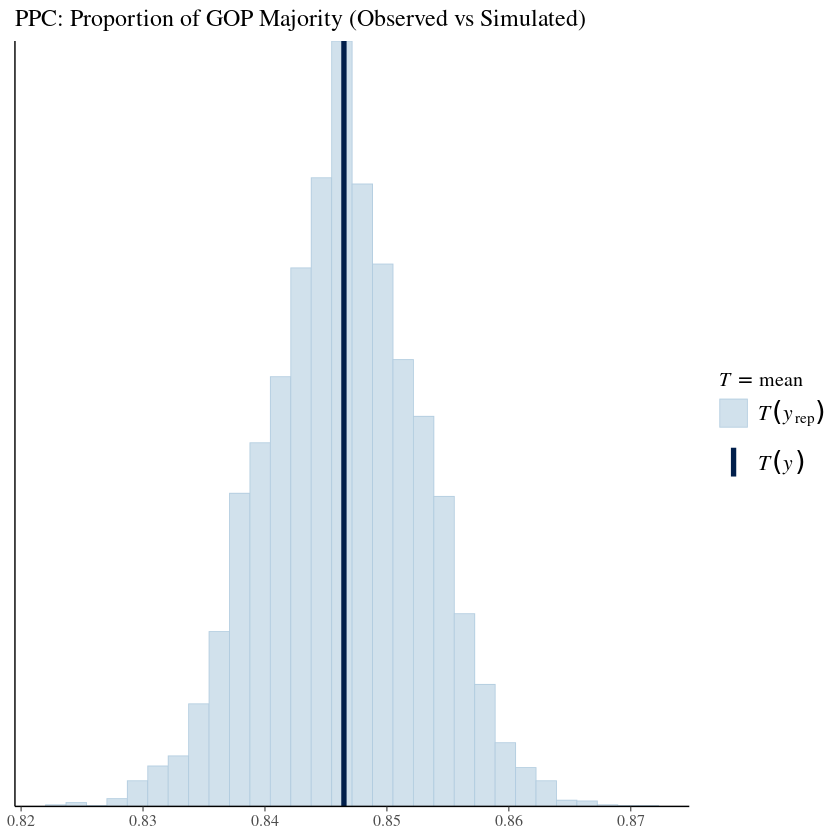

In [69]:
pp_check(model, type = "stat", stat = "mean") +
  labs(title = "PPC: Proportion of GOP Majority (Observed vs Simulated)")

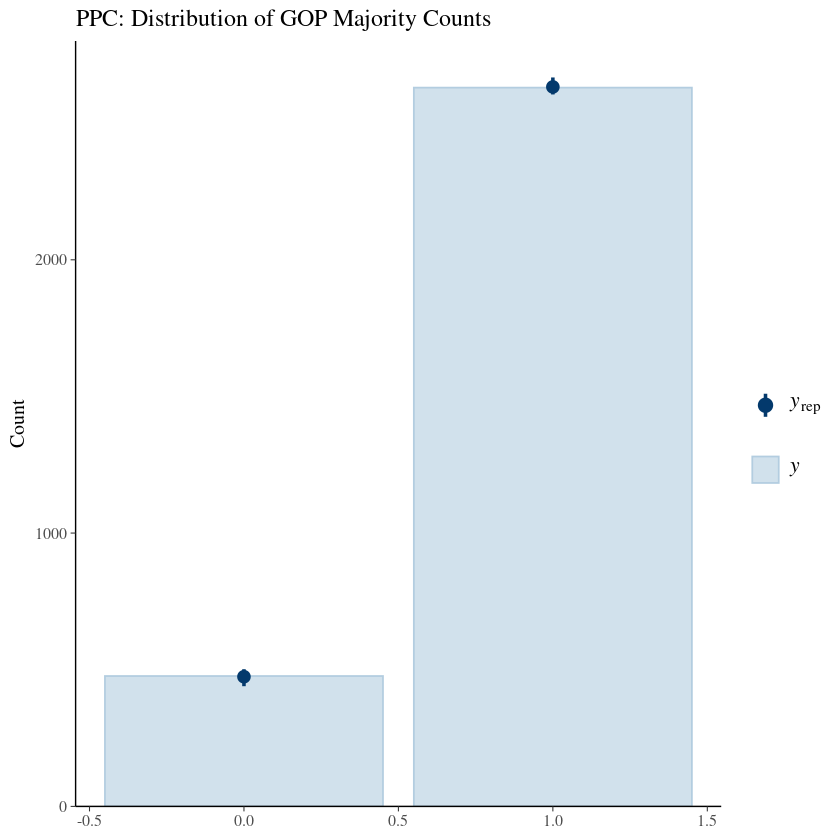

In [70]:
pp_check(model, type = "bars", ndraws = 100) +
  labs(title = "PPC: Distribution of GOP Majority Counts")

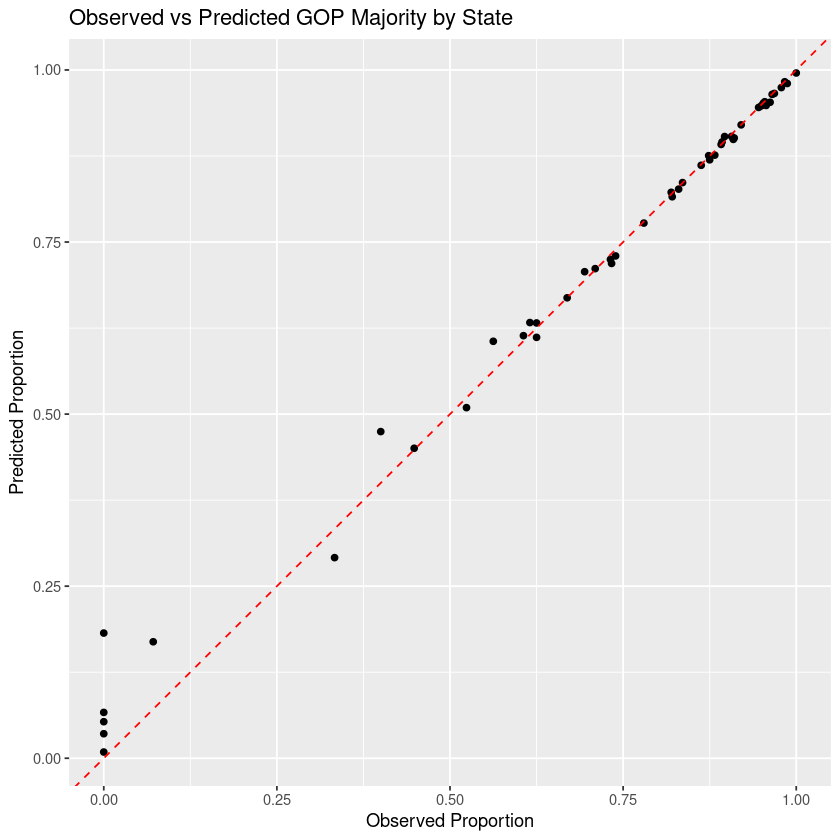

In [73]:
state_pred <- usvotes %>%
  mutate(predicted = fitted(model)[, "Estimate"]) %>%
  group_by(state) %>%
  summarise(
    observed_mean = mean(majority_gop),
    predicted_mean = mean(predicted)
  )

ggplot(state_pred, aes(x = observed_mean, y = predicted_mean)) +
  geom_point() +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "red") +
  labs(title = "Observed vs Predicted GOP Majority by State",
       x = "Observed Proportion",
       y = "Predicted Proportion")


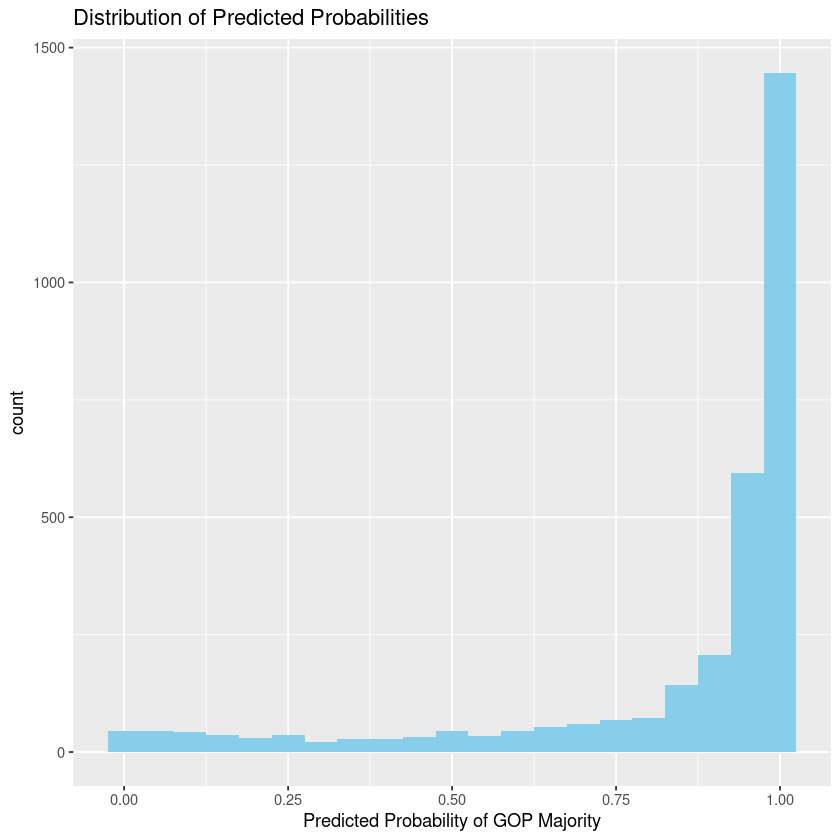

In [72]:
pred_probs <- fitted(model)[, "Estimate"]

ggplot(data.frame(pred = pred_probs, obs = usvotes$majority_gop), aes(x = pred)) +
  geom_histogram(binwidth = 0.05, fill = "skyblue") +
  labs(title = "Distribution of Predicted Probabilities", x = "Predicted Probability of GOP Majority")
